In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.fft import fft, ifft
import seaborn as sns
import xgboost as xgb

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_data = "/content/drive/MyDrive/TEMAS_H/EX1/data_examen_1/train_data"
df_labels=pd.read_csv(f"{ruta_data}/labels_valve_faulty.csv")

import os

# Definir el rango de números de caso
inicio = 106
fin = 153

# Generar la lista de archivos utilizando una comprensión de lista
archivos = [f'Case{numero}.csv' for numero in range(inicio, fin + 1)]

# Inicializar lista vacía para almacenar los DataFrames
dataframes = []

# Iterar sobre los archivos
for archivo in archivos:
    # Leer archivo CSV
    df = pd.read_csv(f"{ruta_data}/data/{archivo}")

    # Extraer el número de caso (esto dependerá de cómo esté estructurado el archivo)
    # Aquí asumimos que el nombre del archivo indica el número del caso, por ejemplo 'Case106.csv'
    case_number = archivo.split('.')[0]

    # Agregar una nueva columna al DataFrame con el nombre del caso
    df['Case#'] = case_number

    # Añadir el DataFrame a la lista
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)

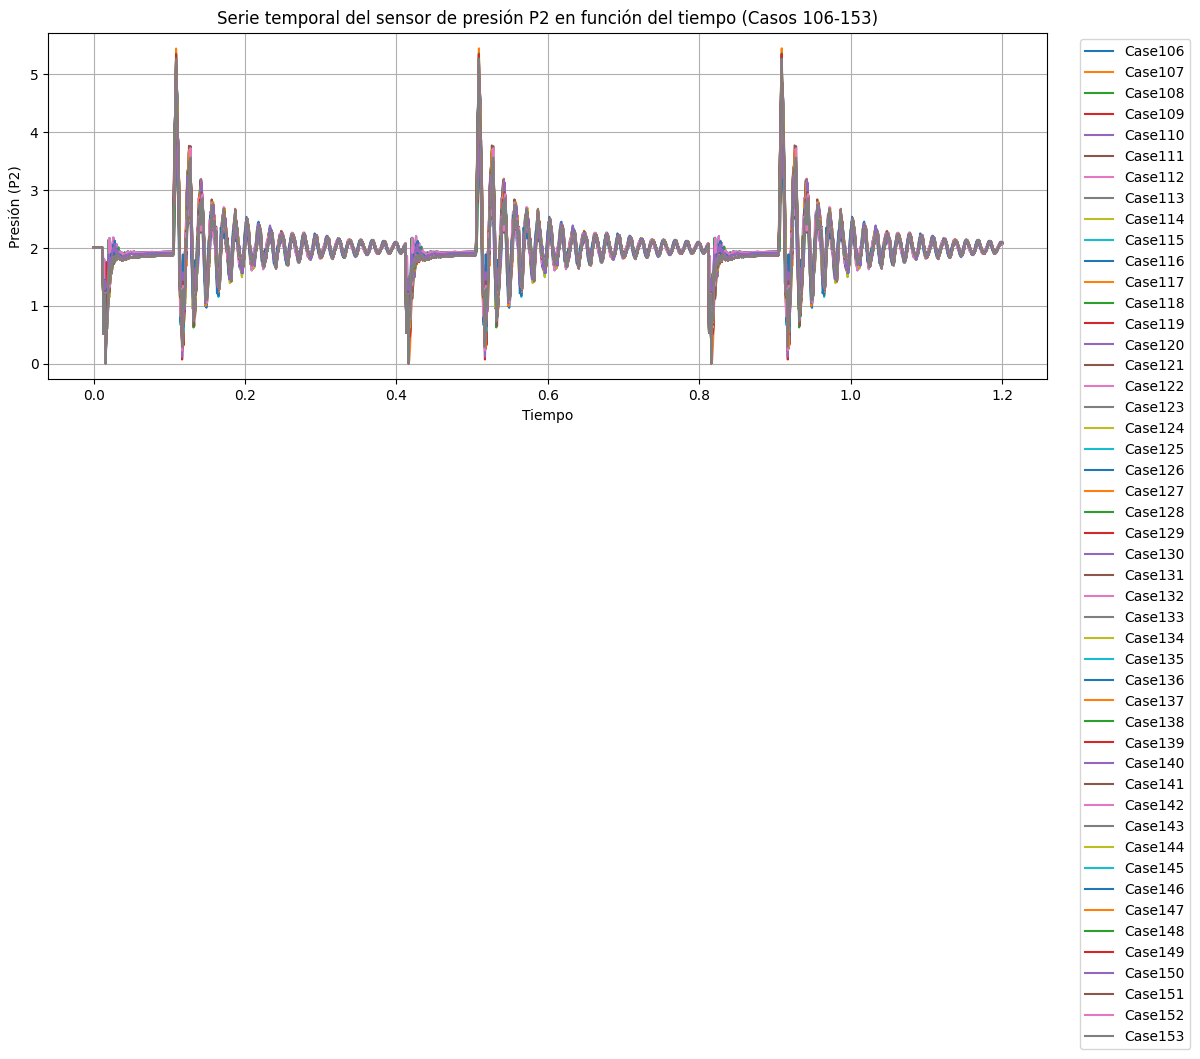

In [ ]:
# Filtrar los datos solo para los casos entre el 106 y el 153
df_filtrado = df_final[df_final['Case#'].isin([f'Case{numero}' for numero in range(106, 154)])]

# Graficar P2 en función del tiempo para cada caso de estudio
plt.figure(figsize=(12, 8))

# Iterar sobre cada caso y graficarlo por separado
for case in df_filtrado['Case#'].unique():
    df_case = df_filtrado[df_filtrado['Case#'] == case]
    plt.plot(df_case['TIME'], df_case['P2'], label=case)

# Configurar el título y etiquetas del gráfico
plt.title('Serie temporal del sensor de presión P2 en función del tiempo (Casos 106-153)')
plt.xlabel('Tiempo')
plt.ylabel('Presión (P2)')
plt.grid(True)

# Mostrar la leyenda con los nombres de los casos
plt.legend( bbox_to_anchor=(1.15, 1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionar solo las columnas P1 a P7, además de la columna 'Case#'
columnas_sensores = ['Case#', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
df_sensores = df_final[columnas_sensores]

# Agrupar por 'Case#' y calcular el promedio para cada sensor
df_promedio = df_sensores.groupby('Case#').mean().reset_index()

# Renombrar las columnas para reflejar que son promedios
df_promedio.columns = ['Case#'] + [f'P{i}_mean' for i in range(1, len(df_promedio.columns))]

# Reiniciar el índice (si es necesario, aunque en este caso ya se hace con el reset_index)
df_promedio.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame resultante
df_promedio.head()


,Case#,P1_mean,P2_mean,P3_mean,P4_mean,P5_mean,P6_mean,P7_mean
0,Case106,1.991155,1.988217,1.990400,1.976915,1.984103,1.972928,1.975697
1,Case107,1.984816,1.975115,1.977205,1.971719,1.978311,1.967569,1.971982
2,Case108,1.984859,1.981055,1.974826,1.975249,1.978066,1.962809,1.970523
3,Case109,1.984876,1.978442,1.973780,1.975830,1.978682,1.965182,1.971662
4,Case110,1.990805,1.988948,1.983286,2.001696,1.986176,1.971578,1.976816


In [ ]:
# Seleccionamos la columna 'Case#' y 'P2' del DataFrame
df_p2 = df_final[['Case#', 'P2']]

# Agrupar por 'Case#' y calcular varias estadísticas sobre P2
df_p2_stats = df_p2.groupby('Case#').agg(
    P2_mean=('P2', 'mean'),
    P2_max=('P2', 'max'),
    P2_min=('P2', 'min'),
    P2_std=('P2', 'std'),
    P2_median=('P2', 'median'),
    P2_25_percentile=('P2', lambda x: x.quantile(0.25)),
    P2_75_percentile=('P2', lambda x: x.quantile(0.75)),
    P2_range=('P2', lambda x: x.max() - x.min())  # Agregando el rango (max - min)
).reset_index()
df_p2_stats.head()

,Case#,P2_mean,P2_max,P2_min,P2_std,P2_median,P2_25_percentile,P2_75_percentile,P2_range
0,Case106,1.988217,4.010017,0.401447,0.365524,1.940395,1.893817,2.092539,3.608571
1,Case107,1.975115,4.692920,0.000779,0.452449,1.932591,1.843229,2.104990,4.692141
2,Case108,1.981055,4.642164,0.003200,0.439097,1.929584,1.843433,2.103779,4.638963
3,Case109,1.978442,4.578231,0.004811,0.445009,1.926497,1.842697,2.104498,4.573420
4,Case110,1.988948,3.832252,0.268050,0.366241,1.939905,1.894922,2.093093,3.564203


In [ ]:
# Paso 2: Convertir la columna 'Case#' en df_labels para que tenga el prefijo 'Case'
df_labels['Case#'] = 'Case' + df_labels['Case#'].astype(str)

# Paso 3: Hacer el merge entre df_p2_stats y df_labels usando la columna 'Case#'
df_agrupado_completo = pd.merge(df_p2_stats, df_labels, on='Case#')

In [ ]:
df_agrupado_completo.head()


,Case#,P2_mean,P2_max,P2_min,P2_std,P2_median,P2_25_percentile,P2_75_percentile,P2_range,Spacecraft#,...,P2_mean_squared,P2_std_cubed,P2_range_log,P2_percentile_diff,P2_std_div_P2_mean,P2_max_div_P2_std,log_P2_mean,sin_P2_mean,P2_diff_max_min,P2_diff_mean_median
0,Case106,1.988217,4.010017,0.401447,0.365524,1.940395,1.893817,2.092539,3.608571,1,...,3.953006,0.048837,1.527918,0.198721,0.183845,10.970606,1.094677,0.914138,3.608571,0.047822
1,Case107,1.975115,4.692920,0.000779,0.452449,1.932591,1.843229,2.104990,4.692141,1,...,3.901080,0.092621,1.739086,0.261761,0.229075,10.372260,1.090283,0.919371,4.692141,0.042524
2,Case108,1.981055,4.642164,0.003200,0.439097,1.929584,1.843433,2.103779,4.638963,1,...,3.924579,0.084661,1.729700,0.260346,0.221648,10.572064,1.092277,0.917018,4.638963,0.051471
3,Case109,1.978442,4.578231,0.004811,0.445009,1.926497,1.842697,2.104498,4.573420,1,...,3.914233,0.088126,1.718009,0.261802,0.224929,10.287962,1.091400,0.918057,4.573420,0.051945
4,Case110,1.988948,3.832252,0.268050,0.366241,1.939905,1.894922,2.093093,3.564203,1,...,3.955916,0.049125,1.518244,0.198171,0.184138,10.463750,1.094922,0.913841,3.564203,0.049044


In [ ]:
X = df_agrupado_completo[['P2_mean', 'P2_max', 'P2_min', 'P2_std', 'P2_median', 'P2_25_percentile', 'P2_75_percentile', 'P2_range']]
y = df_agrupado_completo['TARGET']  # Variable dependiente

In [ ]:

df_agrupado_completo['P2_percentile_diff'] = df_agrupado_completo['P2_75_percentile'] - df_agrupado_completo['P2_25_percentile']
df_agrupado_completo['P2_std_div_P2_mean'] = df_agrupado_completo['P2_std'] / df_agrupado_completo['P2_mean']
df_agrupado_completo['P2_max_div_P2_std'] = df_agrupado_completo['P2_max'] / df_agrupado_completo['P2_std']
df_agrupado_completo['P2_diff_mean_median'] = df_agrupado_completo['P2_mean'] - df_agrupado_completo['P2_median']

# Dividir los datos según la nave espacial
train_data = df_agrupado_completo[df_agrupado_completo['Spacecraft#'].isin([1, 2])]
test_data = df_agrupado_completo[df_agrupado_completo['Spacecraft#'] == 3]

# Separar las variables independientes y dependientes para entrenamiento y validación
X_train = train_data[['P2_mean', 'P2_max', 'P2_min', 'P2_std', 'P2_median', 'P2_25_percentile', 'P2_75_percentile', 'P2_range',
                      'P2_max_div_P2_min', 'P2_std_div_P2_mean', 'P2_max_div_P2_std', 'P2_percentile_diff',
                      'P2_diff_mean_median']]  # Eliminar las características con 0 de importancia
y_train = train_data['TARGET']

X_test = test_data[['P2_mean', 'P2_max', 'P2_min', 'P2_std', 'P2_median', 'P2_25_percentile', 'P2_75_percentile', 'P2_range',
                    'P2_max_div_P2_min', 'P2_std_div_P2_mean', 'P2_max_div_P2_std', 'P2_percentile_diff',
                    'P2_diff_mean_median']]  # Eliminar las características con 0 de importancia
y_test = test_data['TARGET']


In [ ]:
xgb_params = {
    'objective': 'multi:softmax',  # Cambiado a clasificación multiclase
    'learning_rate': 0.0001,
    'max_depth': 50,
    'n_estimators': 500,
    'num_class': len(y_train.unique())  # Especificar el número de clases
}

xgb_clf = xgb.XGBClassifier(**xgb_params)

# Entrenar el clasificador con los datos de entrenamiento
xgb_clf.fit(X_train, y_train);

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Calcular la exactitud del modelo en el conjunto de validación
accuracy_model = accuracy_score(y_test, y_pred)
print(f'Exactitud del modelo entrenado: {accuracy_model:.2f}')


Exactitud del modelo entrenado: 0.62


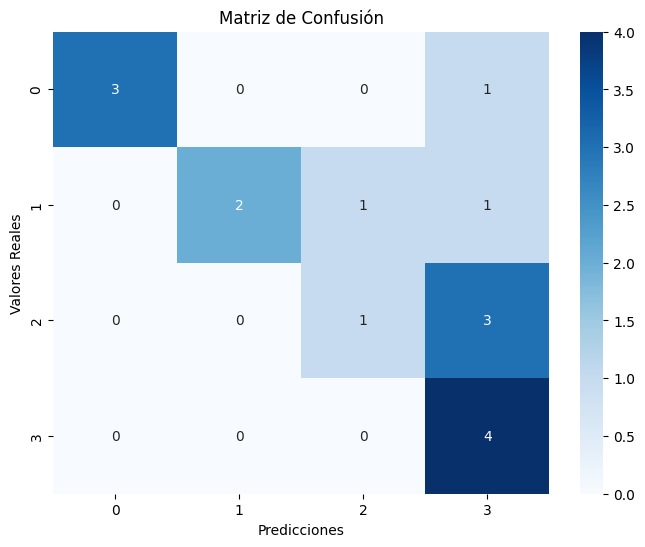

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión utilizando seaborn para mejor visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()

In [ ]:
from collections import Counter
most_common_class = Counter(y_test).most_common(1)[0][0]

# Generar predicciones del BVC (siempre predice la clase más común)
y_bvc_pred = [most_common_class] * len(y_test)

# Calcular la exactitud del BVC
accuracy_bvc = accuracy_score(y_test, y_bvc_pred)
print(f'Exactitud del BVC: {accuracy_bvc:.2f}')


Exactitud del BVC: 0.25


In [ ]:
# Comparación de la exactitud del modelo entrenado vs BVC
print(f"Comparación de exactitudes:\n"
      f"- Modelo entrenado: {accuracy_model:.2f}\n"
      f"- Baseline de Valor Constante (BVC): {accuracy_bvc:.2f}")

if accuracy_model > accuracy_bvc:
    print("El modelo entrenado es superior al BVC en términos de exactitud.")
else:
    print("El BVC es superior o comparable en términos de exactitud.")


Comparación de exactitudes:
- Modelo entrenado: 0.62
- Baseline de Valor Constante (BVC): 0.25
El modelo entrenado es superior al BVC en términos de exactitud.


Los resultados muestran que el modelo entrenado con XGBoost tiene una exactitud del 62%.En comparación, el Baseline de Valor Constante (BVC), que asume que todos los casos pertenecen a la clase más frecuente, tiene una exactitud del 25%. Esto indica que el modelo entrenado es significativamente superior al BVC, ya que utiliza las características de los datos para hacer predicciones más precisas. Mientras que el BVC es una referencia básica que establece el mínimo rendimiento esperado, el modelo entrenado ofrece una mejora sustancial, lo que sugiere que está capturando patrones útiles en los datos y generalizando mejor que simplemente adivinar la clase más frecuente.

In [ ]:
submission_file = pd.DataFrame({
    'ID': range(138, 154),  # ID consecutivos de 138 a 153
    'TARGET': y_pred  # Predicciones para Spacecraft 3
})


# Guardar el DataFrame en la ruta especificada
ruta_guardado = '/content/drive/MyDrive/TEMAS_H/EX1/submission_file.csv'
submission_file.to_csv(ruta_guardado, index=False)

